
**Arya Rahmanian**  
**Texas A&M University**  
**Machine Learning Project Spring 2023**  

## Data Preparation

In [74]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

We will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [75]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [76]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

## Data Exploration

In [77]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [78]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: Dress (3)


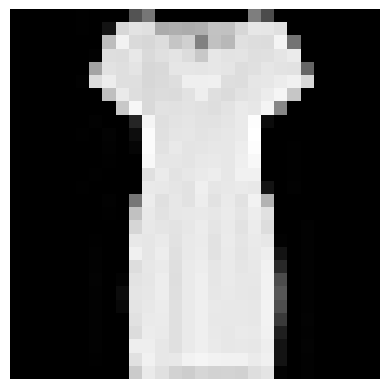

In [79]:
show_example(*dataset[20])

Label: Sneaker (7)


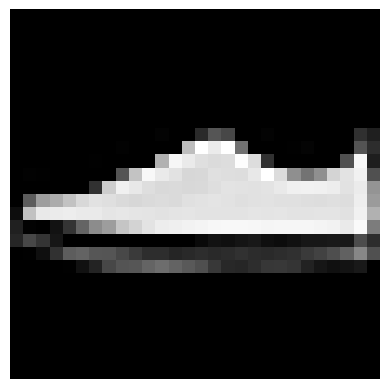

In [80]:
show_example(*dataset[20000])

## Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.  


In [81]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [82]:

val_frac =  .4 ## Set the fraction for the validation set
rand_seed =  99 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))

#samples in training set: 36000
#samples in validation set: 24000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 



In [83]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [84]:

batch_size =  64 ## Set the batch size

In [85]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size=batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size=batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [86]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


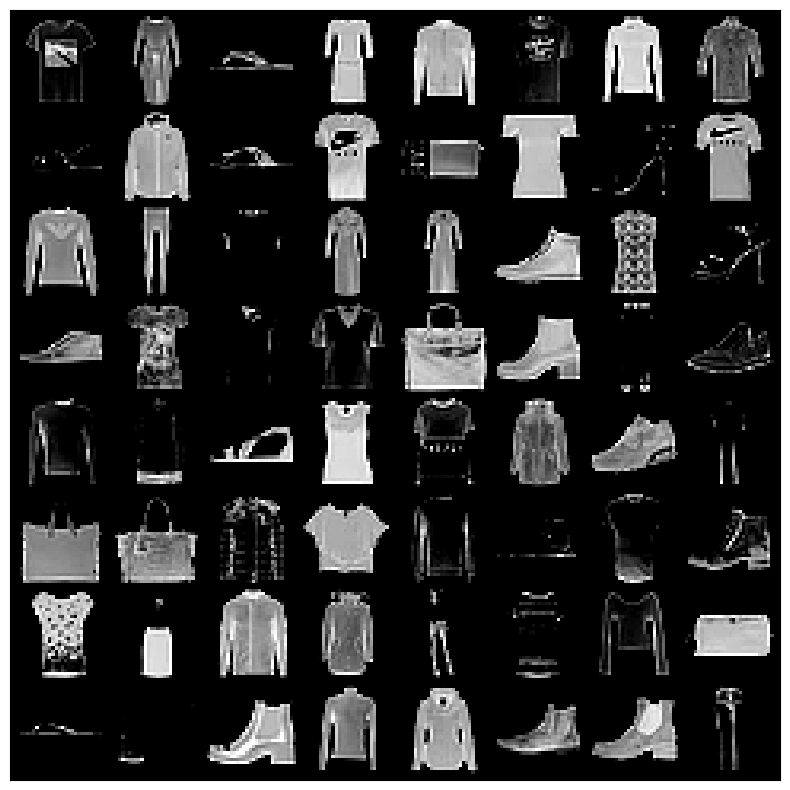

In [87]:
show_batch(train_dl)

## Building the Model

Createing model by defining the network architecture in the `ImageClassifierNet` class.  
**NOTE: I am keeping parameters $\leq$ 100,000.**

In [88]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [89]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
 
           
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=n_channels, out_channels=8, kernel_size=3, padding=1),nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),nn.BatchNorm2d(16),nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc1 = nn.Linear(in_features=16*6*6, out_features=128)
        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, X):
        x = self.layer1(X)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        
        return x

In [90]:
model = ImageClassifierNet()

In [91]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Sequential: 1-1                        [64, 8, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 8, 28, 28]           80
│    └─BatchNorm2d: 2-2                  [64, 8, 28, 28]           16
│    └─ReLU: 2-3                         [64, 8, 28, 28]           --
│    └─MaxPool2d: 2-4                    [64, 8, 14, 14]           --
├─Sequential: 1-2                        [64, 16, 6, 6]            --
│    └─Conv2d: 2-5                       [64, 16, 12, 12]          1,168
│    └─BatchNorm2d: 2-6                  [64, 16, 12, 12]          32
│    └─ReLU: 2-7                         [64, 16, 12, 12]          --
│    └─MaxPool2d: 2-8                    [64, 16, 6, 6]            --
├─Linear: 1-3                            [64, 128]                 73,856
├─Dropout: 1-4                           [64, 128]                 --
├─Linear

## Enable training on a GPU

In [93]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [94]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ImageClassifierNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Train the model

In [95]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    loss_list = []
    iteration_list = []
    accuracy_list = []
    
    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []
    count = 0
    # Change learning rate
    for g in opt_fn.param_groups:
        g['lr'] = lr
      
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        train_loss, train_accuracy = 0.0, 0.0  # Track the training loss and accuracy for this epoch
        correct = 0.0 
        total = 0.0
        for inputs, labels in train_dl:
            images, labels = inputs.to(device), labels.to(device) #move to GPU or CPU
            
            outputs = model(images)  # forward pass
            loss = loss_fn(outputs, labels)  #get loss
            opt_fn.zero_grad() 
            loss.backward()  #backward pass
            opt_fn.step()  # update  param
            train_loss += loss.item() * batch_size  #track loss
            _, preds = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            #train_accuracy += torch.sum(preds == labels.data)  # Track the total number of correct predictions

        # compute the average loss and accuracy for this epoch
        train_loss = train_loss
        train_accuracy = 100 * correct / total

        #validation
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        val_total , val_correct = 0.0 , 0.0
        if val_dl:
            with torch.no_grad():
                for inputs, labels in val_dl:
                    images, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item() * batch_size
                    _, preds = torch.max(outputs, 1)

                    val_total += labels.size(0)
                    val_correct += (preds == labels).sum().item()
            val_loss = val_loss
            if val_total != 0:
                val_accuracy = 100 * val_correct / val_total
            else:
                val_accuracy = None
        else:
            val_accuracy = None

        # record the loss and accuracy for this epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print progress
        if val_accuracy is not None:
            print("Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, val_loss, train_accuracy, val_accuracy))
        else:
            print("Epoch {}/{}, train_loss: {:.4f}, train_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, train_accuracy))
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [96]:

import torch.optim as optim
from torch.optim import SGD
num_epochs = 30 # Max number of training epochs
loss_fn = nn.CrossEntropyLoss() # Define the loss function
lr = 0.0001 # Set the learning rate
#opt_fn = optim.SGD(model.parameters(), lr=lr)  # Select an optimizer function
opt_fn = torch.optim.Adam(model.parameters(), lr=lr) # Select an optimizer function


In [97]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Epoch 1/30, train_loss: 31206.6182, val_loss: 12598.0299, train_accuracy: 71.8194, val_accuracy: 80.3875
Epoch 2/30, train_loss: 17354.0426, val_loss: 10217.5177, train_accuracy: 82.5778, val_accuracy: 84.6125
Epoch 3/30, train_loss: 15049.4236, val_loss: 9394.4064, train_accuracy: 85.0861, val_accuracy: 85.8417
Epoch 4/30, train_loss: 13795.8159, val_loss: 8843.0656, train_accuracy: 86.4972, val_accuracy: 86.6917
Epoch 5/30, train_loss: 13005.4451, val_loss: 8403.2848, train_accuracy: 87.1556, val_accuracy: 87.2958
Epoch 6/30, train_loss: 12475.8207, val_loss: 8173.2760, train_accuracy: 87.7694, val_accuracy: 87.8417
Epoch 7/30, train_loss: 11980.7014, val_loss: 8028.5234, train_accuracy: 88.2028, val_accuracy: 88.1750
Epoch 8/30, train_loss: 11557.2983, val_loss: 7919.5920, train_accuracy: 88.6444, val_accuracy: 88.3042
Epoch 9/30, train_loss: 11214.5314, val_loss: 7791.7959, train_accuracy: 88.9611, val_accuracy: 88.6000
Epoch 10/30, train_loss: 11078.4687, val_loss: 7680.0764, trai

## Plot loss and accuracy



In [98]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

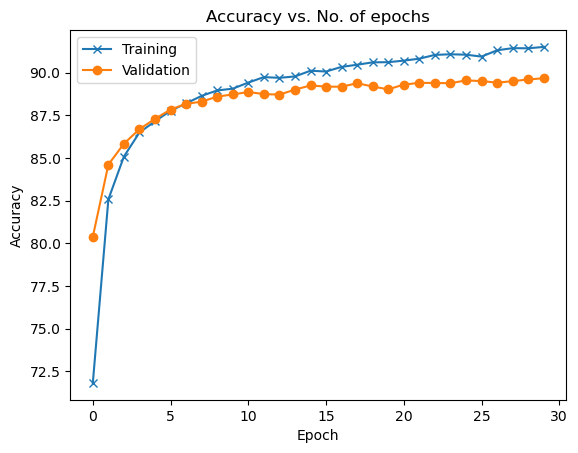

In [99]:
plot_accuracy(train_accuracies, val_accuracies)

In [100]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

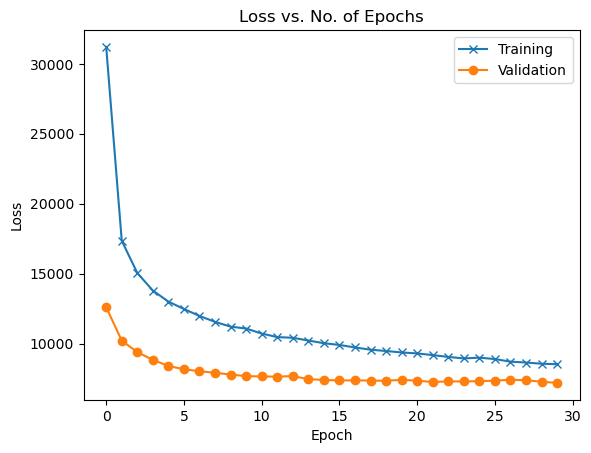

In [101]:
plot_losses(train_losses, val_losses)

## Train a model on the entire dataset

We create a new model with the architecture based on hyperparameter tuning step and train it on the whole training data.

In [102]:
new_model = ImageClassifierNet()


In [108]:
to_device(new_model, device)


Device being used: cuda
Number of available GPUs: 1
Current GPU index: 0
Number of CUDA cores: 304


In [104]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

In [ ]:


num_epochs = 75 # Max number of training epochs
lr = 0.001 # Set the learning rate
opt_fn = torch.optim.Adam(new_model.parameters(), lr=lr) # Select an optimizer function
history = train_model(num_epochs, new_model, dl, [], loss_fn, opt_fn, lr)
new_model = history[0]

Epoch 1/75, train_loss: 16257.2042, train_accuracy: 90.2567
Epoch 2/75, train_loss: 15394.7032, train_accuracy: 90.6817
Epoch 3/75, train_loss: 15193.9329, train_accuracy: 90.8333
Epoch 4/75, train_loss: 14757.0704, train_accuracy: 91.0483
Epoch 5/75, train_loss: 14794.0159, train_accuracy: 90.9900
Epoch 6/75, train_loss: 14295.0691, train_accuracy: 91.3117
Epoch 7/75, train_loss: 14364.8880, train_accuracy: 91.2667
Epoch 8/75, train_loss: 14080.7579, train_accuracy: 91.4933
Epoch 9/75, train_loss: 13871.1290, train_accuracy: 91.5500
Epoch 10/75, train_loss: 13668.7708, train_accuracy: 91.7683
Epoch 11/75, train_loss: 13603.6716, train_accuracy: 91.6433
Epoch 12/75, train_loss: 13589.2144, train_accuracy: 91.7567
Epoch 13/75, train_loss: 13393.8383, train_accuracy: 91.8000
Epoch 14/75, train_loss: 13279.7870, train_accuracy: 91.9550
Epoch 15/75, train_loss: 13071.7721, train_accuracy: 92.0817
Epoch 16/75, train_loss: 13027.4077, train_accuracy: 92.0850
Epoch 17/75, train_loss: 12933.58

## Check Predictions

In [110]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

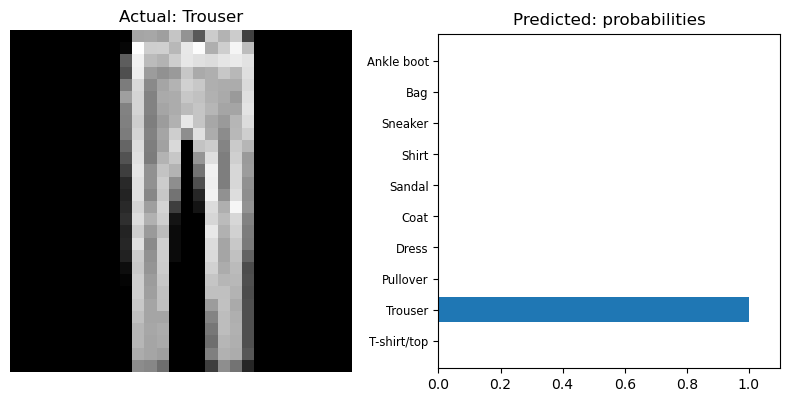

In [111]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        new_model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(new_model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

## Save the model

In [112]:
torch.save(new_model, 'new_model')

## Compute accuracy on the test set

In [113]:
import pickle

In [114]:

test_dataset_file_path = "test_data.pickle"

with open(test_dataset_file_path, 'rb') as f:
    test_dataset = pickle.load(f)

In [115]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [116]:
def evaluate(model, test_dl):
    with torch.no_grad():
        model.eval()
        total_test_dl = 0
        preds, labels = [], []
        for xb, yb in test_dl:
            # Model output
            y_pred = model(xb)
            _, y_pred = torch.max(y_pred, dim=1)
            preds.extend(y_pred)
            labels.extend(yb)               
            total_test_dl += len(yb)

    preds, labels = torch.tensor(preds), torch.tensor(labels)
    test_accuracy = torch.sum(preds == labels).item() / len(preds)
    return test_accuracy

In [117]:
print("Test Accuracy = {:.4f}".format(evaluate(new_model, test_dl)))

Test Accuracy = 0.8966
